TensorFlow2.x 基于LSTM单变量预测_电力消耗

数据集：DOM_hourly.csv

1. 加载数据集、预处理
2. 特征工程
3. 构建模型
4. 模型编译、训练、验证
5. 模型测试
6. 可视化结果

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils

import warnings
warnings.filterwarnings("ignore")

# 第1步：加载数据集、预处理

In [7]:
# 读取数据集
dataset = pd.read_csv("DOM_hourly.csv")

In [8]:
# 显示shape
dataset.shape

(116189, 2)

In [9]:
# 默认显示前5行
dataset.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [10]:
# 显示数据描述,统计所有数值类型的列，对于object类型的这种数据列是不会去统计的
dataset.describe()

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


In [11]:
# 显示字段数据类型
dataset.dtypes

Datetime     object
DOM_MW      float64
dtype: object

In [12]:
# 将字段Datetime数据类型转换为日期类型, 但是原来的数据必须是时间格式
dataset["Datetime"] = pd.to_datetime(dataset['Datetime'], format="%Y-%m-%d %H:%M:%S")

In [13]:
dataset.dtypes

Datetime    datetime64[ns]
DOM_MW             float64
dtype: object

In [14]:
# 将字段Datetime 设置为索引列
# 目的：后续基于索引来进行数据集的切分
dataset.index = dataset.Datetime

In [15]:
dataset.head()

,Datetime,DOM_MW
Datetime,,
2005-12-31 01:00:00,2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,2005-12-31 05:00:00,9132.0


In [16]:
# 将原始的Datetime 字段列删除;
# columns 删除哪一列，可以填好几列
# axis 表示纵向，列
# inplace=True是对原始的数据做一个删除
dataset.drop(columns=['Datetime'], axis=1, inplace=True)

In [17]:
dataset.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


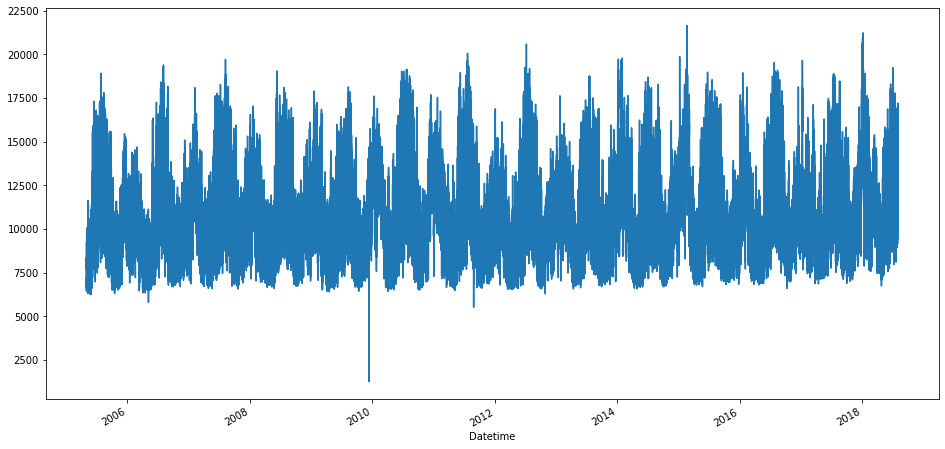

In [18]:
# 可视化显示数据分布情况
# figsize: 图片的大小
dataset['DOM_MW'].plot(figsize=(16,8))
plt.show()

In [19]:
# 数据归一化
scaler = MinMaxScaler()
dataset['DOM_MW'] = scaler.fit_transform(dataset['DOM_MW'].values.reshape(-1, 1))
# (-1, 1) -1 表示你这里无论多少行，自己去计算。1 表示1列。

In [ ]:
dataset.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,0.398863
2005-12-31 02:00:00,0.383224
2005-12-31 03:00:00,0.379841
2005-12-31 04:00:00,0.381851
2005-12-31 05:00:00,0.386263


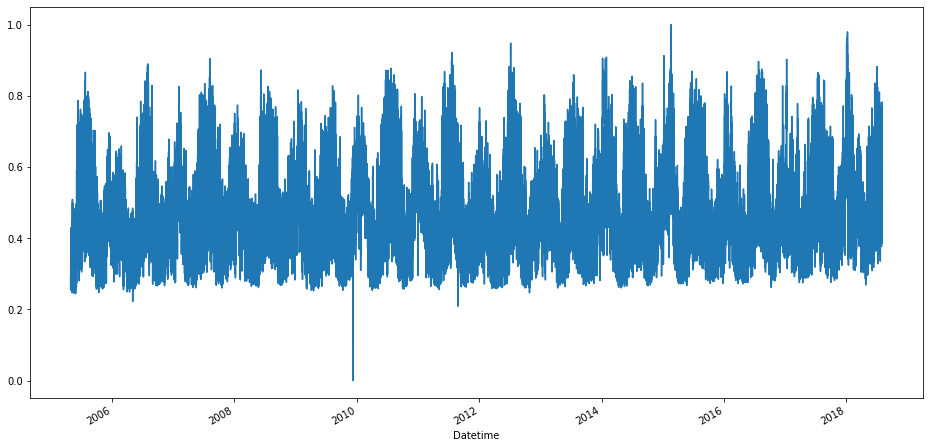

In [20]:
# 可视化显示数据分布情况
# figsize: 图片的大小
dataset['DOM_MW'].plot(figsize=(16,8))
plt.show()

# 第2步：特征工程

In [31]:
# 功能函数：构造特征集和标签集
def create_new_dataset(dataset, seq_len = 12):
  '''基于原始数据集构造新的序列特征数据集
  Params：
    dataset: 原始数据集
    seq_len: 序列长度（时间跨度），相当于滑窗
  '''
  X = []  # 初始特征数据集为空列表
  y = []  # 初始标签数据集为空列表

  start = 0  # 初始位置
  end = dataset.shape[0] - seq_len  # 截止位置

  for i in range(start, end):  # for 循环构造特征数据集
    sample = dataset[i: i + seq_len]  # 基于时间跨度seq_len 创建样本
    lable = dataset[i + seq_len]    # 创建sample 对应的标签
    X.append(sample)  # 保存sample
    y.append(lable)  # 保存label
  
  # 返回特征数据集和标签集
  return np.array(X), np.array(y)

In [29]:
# 功能函数：基于新的特征的数据集和标签集，切分：X_train, X_test
# 这个数据集的切分是有时间前后关系的
# 就是切片处理
def split_dataset(X, y, train_ratio=0.8):
  '''
  X: 特征数据集
  y: 标签数据集
  train_ratio: 训练集占X的比例
  '''
  X_len = len(X)  # 特征数据集X的样本容量
  train_data_len = int(X_len * train_ratio) # 训练集的样本容量

  X_train = X[:train_data_len]  # 训练集
  y_train = y[:train_data_len]  # 训练标签集

  X_test = X[train_data_len:]  # 测试集
  y_test = y[train_data_len:]  # 测试标签集

  # 返回值
  return X_train, X_test, y_train, y_test

In [23]:
# 功能函数：基于新的X_train, X_test, y_train, y_test创建批数据(batch dataset)
def create_batch_data(X, y, batch_size=32, data_type=1):
  '''基于训练集和测试集，创建批数据
  X: 训练标签集
  y： 标签数据集
  batch_size: batch的大小，即一个数据块里面有几个样本
  data_type: 1 表示测试机，else 表示训练集
  '''
  if data_type == 1:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))  # 封装X和y成为tensor类型
    test_batch_data = dataset.batch(batch_size)  # 构造批数据
    return test_batch_data
  else:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    train_batch_data = dataset.cache().shuffle(1000).batch(batch_size)  # cache()：将数据加载到内存中去，shuffle():打乱
    return train_batch_data

In [24]:
# 原始数据集
dataset_original = dataset

In [25]:
print("原始数据集：", dataset_original.shape)

原始数据集： (116189, 1)


In [32]:
# 构造特征集和标签集
SEQ_LEN = 20  # 序列长度
X, y = create_new_dataset(dataset_original.values, seq_len=SEQ_LEN)

In [33]:
X.shape

(116169, 20, 1)

In [34]:
y.shape

(116169, 1)

In [35]:
# 样本1 - 特征数据
X[0]

array([[0.39886263],
       [0.38322385],
       [0.37984116],
       [0.38185116],
       [0.38626336],
       [0.39709775],
       [0.41518776],
       [0.43827826],
       [0.45754486],
       [0.47372291],
       [0.47455633],
       [0.46303559],
       [0.44460241],
       [0.4206785 ],
       [0.40445142],
       [0.39910776],
       [0.4164624 ],
       [0.47651731],
       [0.49068536],
       [0.47519365]])

In [37]:
# 样本1 - 标签
y[0]

array([0.46450632])

In [38]:
# 数据切分
X_train, X_test, y_train, y_test = split_dataset(X, y)

In [39]:
X_train.shape

(92935, 20, 1)

In [41]:
y_train.shape

(92935, 1)

In [40]:
X_test.shape

(23234, 20, 1)

In [42]:
y_test.shape

(23234, 1)

In [46]:
# 基于新的X_train, X_test, y_train, y_test创建批数据 batch dataset
# 测试批数据
test_batch_dataset = create_batch_data(X_test, y_test, batch_size=64, data_type=1)

In [47]:
# 训练批数据
train_batch_dataset = create_batch_data(X_train, y_train, batch_size=64, data_type=2)

# 第3步：构造模型

In [49]:
model = Sequential([
      layers.LSTM(8, input_shape=(SEQ_LEN, 1)),
      layers.Dense(1)
])

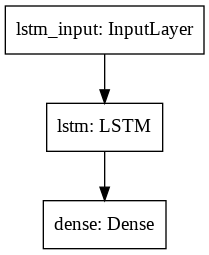

In [50]:
# 显示模型结构
utils.plot_model(model)

In [51]:
# 定义checkpoint, 保存权重文件
file_path = 'best_checkpoint.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                             monitor='loss',  # 检测值，检测训练的loss，保存loss最小的模型
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True
                              )

# 第4步：模型编译、训练、验证

In [53]:
# 模型编译
model.compile(optimizer='adam', loss='mae')

In [54]:
# 模型训练
history = model.fit(train_batch_dataset, epochs=10,validation_data=test_batch_dataset,callbacks=[checkpoint_callback])

Epoch 1/10
1453/1453 [==============================] - 12s 7ms/step - loss: 0.0360 - val_loss: 0.0183
Epoch 2/10
1453/1453 [==============================] - 10s 7ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 3/10
1453/1453 [==============================] - 10s 7ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 4/10
1453/1453 [==============================] - 10s 7ms/step - loss: 0.0126 - val_loss: 0.0129
Epoch 5/10
1453/1453 [==============================] - 10s 7ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 6/10
1453/1453 [==============================] - 10s 7ms/step - loss: 0.0122 - val_loss: 0.0126
Epoch 7/10
1453/1453 [==============================] - 10s 7ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 8/10
1453/1453 [==============================] - 10s 7ms/step - loss: 0.0119 - val_loss: 0.0125
Epoch 9/10
1453/1453 [==============================] - 10s 7ms/step - loss: 0.0117 - val_loss: 0.0124
Epoch 10/10
1453/1453 [==============================] - 10s 7ms/step - l

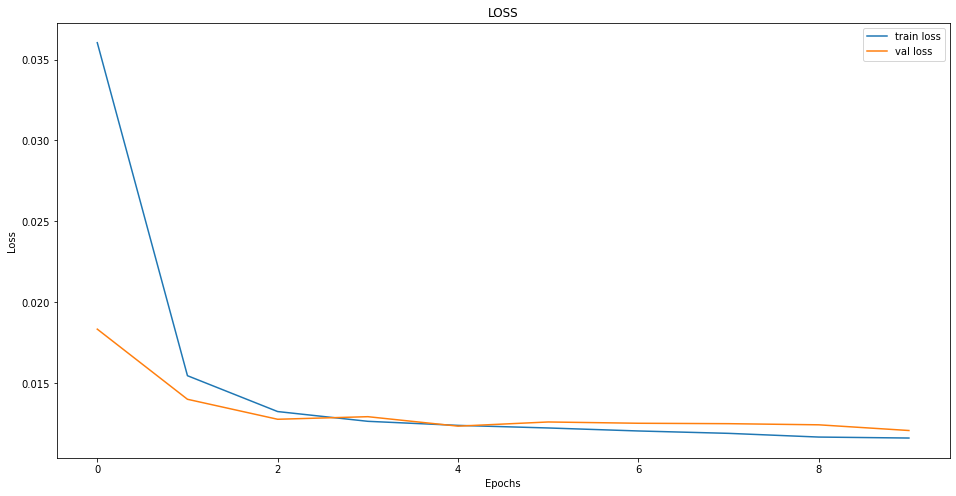

In [56]:
# 显示train loss 和 val loss
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [57]:
# 模型验证
test_pred = model.predict(X_test, verbose=1)

727/727 [==============================] - 2s 2ms/step


In [58]:
test_pred.shape  # 预测值的shape

(23234, 1)

In [59]:
y_test.shape   # 真值标签的shape

(23234, 1)

In [60]:
# 计算 r2，回归案例一般用r2值来计算,衡量模型的性能，拟合的效果是怎样的
score = r2_score(y_test, test_pred)

In [61]:
print("r^2 的值：", score)

r^2 的值： 0.9689508976028507


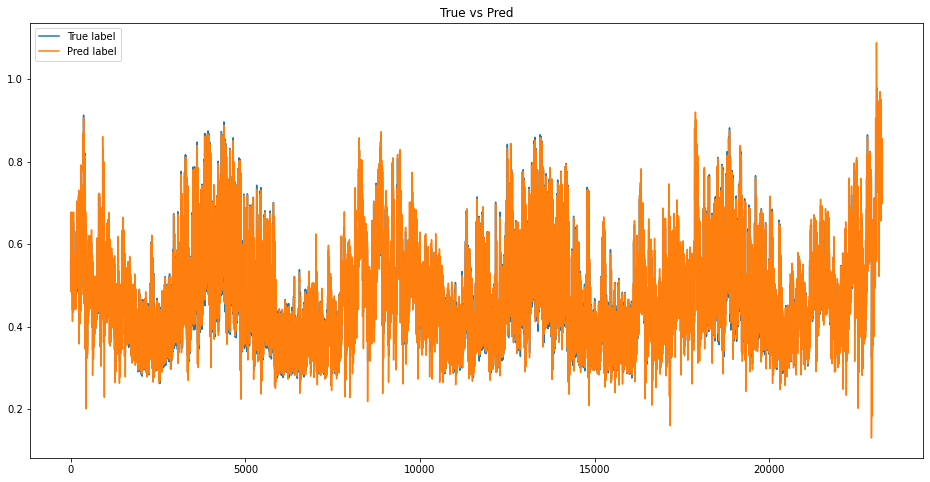

In [62]:
# 绘制模型验证结果
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='True label')
plt.plot(test_pred, label='Pred label')
plt.title('True vs Pred')
plt.legend(loc='best')
plt.show()

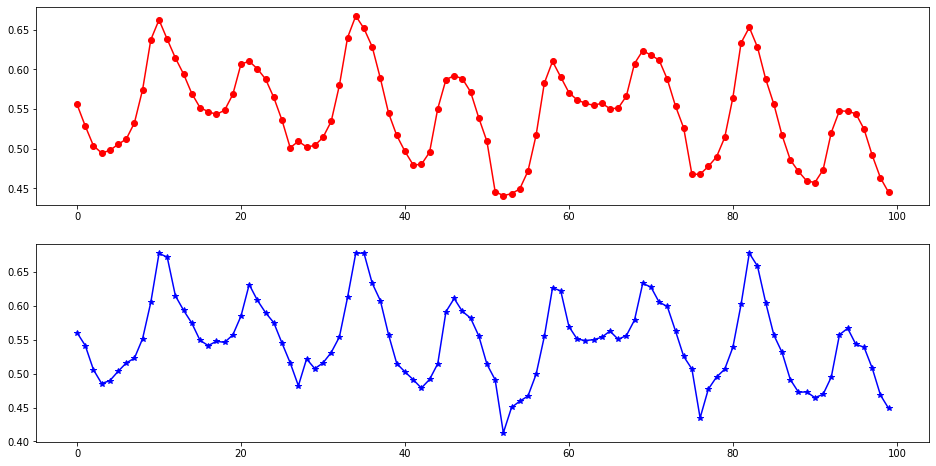

In [63]:
# 绘制test中前100个点的真值和预测值
y_true = y_test[:100]
y_pred = test_pred[:100]

fig, axes = plt.subplots(2, 1, figsize=(16, 8))
axes[0].plot(y_true, marker='o', color='red')
axes[1].plot(y_pred, marker='*', color='blue')
plt.show()

# 第5步：模型测试

In [71]:
# 选择test中的最后一个样本
sample = X_test[-1]
sample.shape

(20, 1)

In [72]:
sample = sample.reshape(1, sample.shape[0], 1)  # 第一个1 是batch size，

In [74]:
sample.shape  # 符合LSTM网络模型输入的shape

(1, 20, 1)

In [77]:
# 模型预测
sample_pred = model.predict(sample)
sample_pred

array([[0.79405653]], dtype=float32)

In [78]:
# 预测后续20个点的值
true_data = X_test[-1]
true_data

array([[0.77978233],
       [0.79566624],
       [0.81694284],
       [0.83297382],
       [0.84434749],
       [0.83120894],
       [0.79287185],
       [0.76370232],
       [0.73982743],
       [0.72595352],
       [0.70825571],
       [0.69791156],
       [0.70619669],
       [0.74360231],
       [0.81125601],
       [0.83321894],
       [0.84150407],
       [0.84880871],
       [0.83606236],
       [0.81189332]])

In [79]:
true_data.shape

(20, 1)

In [80]:
list(true_data[:, 0])

[0.7797823316011374,
 0.7956662417884106,
 0.8169428375330915,
 0.8329738209628395,
 0.8443474850475536,
 0.8312089420531424,
 0.7928718501813903,
 0.7637023237572311,
 0.739827434062163,
 0.725953524855378,
 0.7082557113442495,
 0.6979115599568585,
 0.7061966859496029,
 0.7436023139523482,
 0.8112560054907344,
 0.8332189430336308,
 0.8415040690263751,
 0.8488087067359545,
 0.8360623590548093,
 0.8118933228747917]

In [83]:
def predict_next(model, sample, epoch=20):
  templ = list(sample[:,0])
  for i in range(epoch):
    sample = sample.reshape(1, SEQ_LEN, 1)
    pred = model.predict(sample)
    value = pred.tolist()[0][0]
    templ.append(value)
    sample = np.array(templ[i + 1: i + SEQ_LEN + 1])
  return templ

In [84]:
preds = predict_next(model, true_data, 20)

In [87]:
len(preds)

40

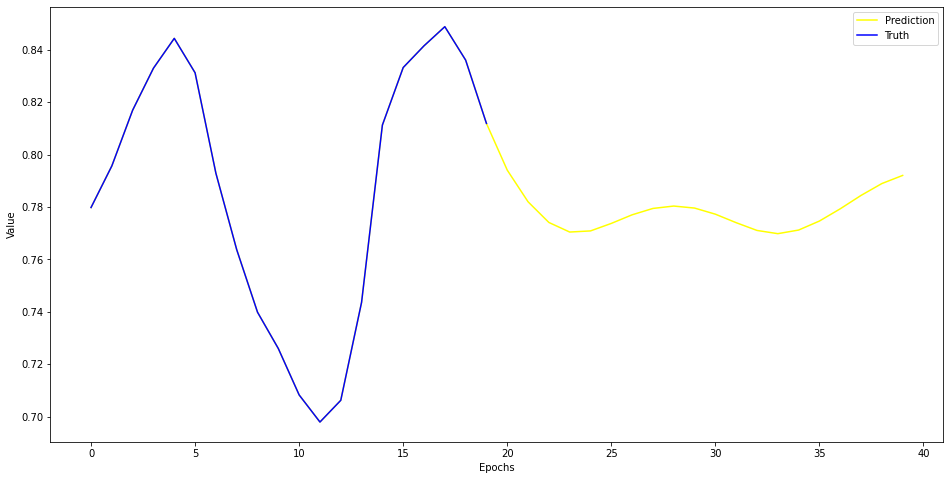

In [88]:
plt.figure(figsize=(16,8))
plt.plot(preds,color = 'yellow', label='Prediction')
plt.plot(true_data, color='blue', label='Truth')
plt.xlabel("Epochs")
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()